## Part 2: Profit calculation and analysis

### (a) Delta hedging efficiency

#### (i) Plot

In [125]:
import numpy as np
from final.random import StandardNormalRNG, GBMPathGenerator, Paths
import final.blackscholes as bs
import matplotlib.pyplot as plt

In [126]:
# Set up parameters
S0 = 100  # Initial stock price
K = 105   # Strike price
r = 0.04  # Risk-free rate
q = 0     # Dividend yield
v = 0.3  # Volatility
T = 2     # Time to maturity
num_paths = 2000
num_steps = 252*T

function to simulate DELTA hedging 

In [127]:
def simulate_delta_hedging(paths, delta_values, rebalance_freq):
    
    pnl = np.zeros(num_paths)
    rebalance_steps = max(1, int(num_steps / rebalance_freq))
    
    # Calculating initial option premium
    initial_option_price = bs.put_price(s=S0, k=K, r=r, q=q, v=v, t=T)
    
    for i in range(num_paths):
        # Initializing with option premium and initial hedge
        cash_account = initial_option_price - delta_values[i, 0] * paths[i, 0]
        stock_position = delta_values[i, 0]
        
        for t in range(1, num_steps + 1):

            # Updating cash account with compounding interest
            cash_account *= np.exp(r * paths.time_step)
            
            # Rebalancing at specified frequency
            if t % rebalance_steps == 0 and t < num_steps:
                new_stock_position = delta_values[i, t]
                cash_account -= (new_stock_position - stock_position) * paths[i, t]
                stock_position = new_stock_position
        
        # Final settlement
        # Put option payoff
        option_payoff = max(K - paths[i, -1], 0)  
        final_stock_value = stock_position * paths[i, -1]
        
        pnl[i] = cash_account + final_stock_value - option_payoff
    
    return np.mean(pnl), np.std(pnl)


function for producing graphs

In [128]:
def plot_hedging_results(freq_labels, means, stds):
    """
    Plot hedging results with error bars.
    """
    plt.figure(figsize=(12, 6))
    
    # Plotting mean P&L with error bars (standard deviation)
    plt.errorbar(range(len(freq_labels)), means, yerr=stds, 
                fmt='o-', capsize=5, markersize=8, 
                color='blue', ecolor='red', 
                label='Mean P&L ± Std Dev')
    
    # Customizing plot
    plt.xlabel('Rebalancing Frequency', fontsize=12)
    plt.ylabel('P&L', fontsize=12)
    plt.title('Hedging P&L vs Rebalancing Frequency', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(len(freq_labels)), freq_labels, rotation=45)
    plt.legend()
    
    # Add zero line for reference
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    return plt.gcf()

Running simulations fro Delta hedging

C:\Users\bhanu\OneDrive\Desktop\MFM\Semester 1\Python fm5151\final_starter\starter\pkg\src\final\blackscholes.py:27: RuntimeWarning: divide by zero encountered in divide
  if t == 0:


Frequency: Monthly, Mean P&L: -0.0207, Std Dev P&L: 4.3445
Frequency: Bi-monthly, Mean P&L: -0.1410, Std Dev P&L: 5.9773
Frequency: Weekly, Mean P&L: -0.0456, Std Dev P&L: 2.0766
Frequency: Bi-weekly, Mean P&L: -0.0036, Std Dev P&L: 2.9216
Frequency: Daily, Mean P&L: -0.0124, Std Dev P&L: 0.9662
Frequency: 2x Day, Mean P&L: 0.0019, Std Dev P&L: 0.6945
Frequency: 4x Day, Mean P&L: 0.0019, Std Dev P&L: 0.6945
Frequency: 8x Day, Mean P&L: 0.0019, Std Dev P&L: 0.6945


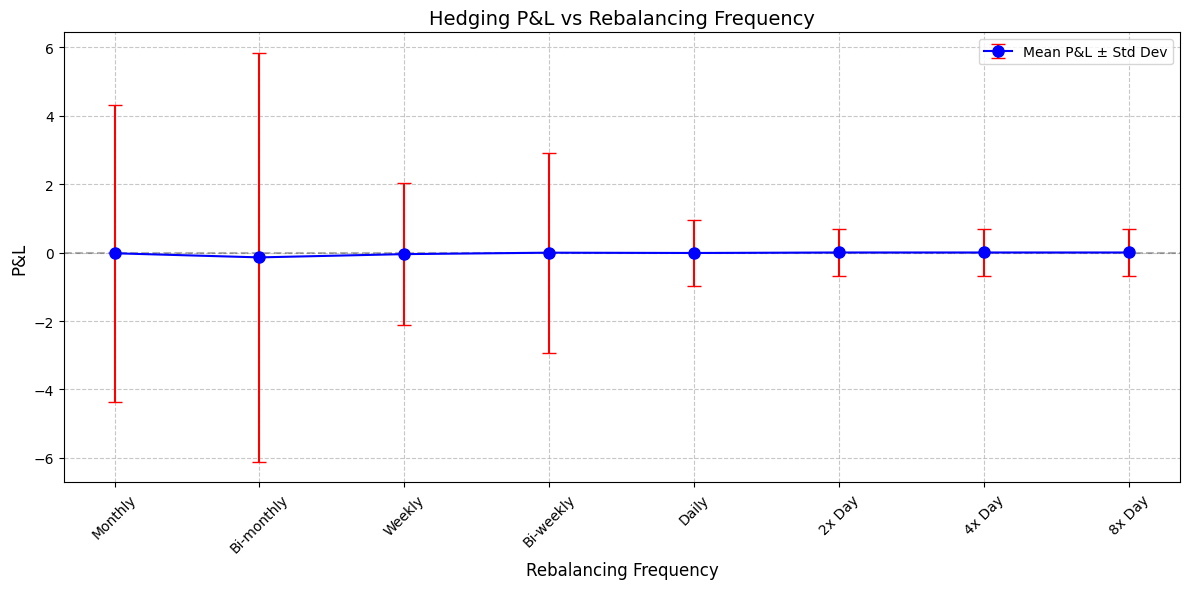

In [129]:
# Initializing random number generator and path generator
rng = StandardNormalRNG(seed=50)

gbm_generator = GBMPathGenerator(num_paths=num_paths, num_steps=num_steps, s0=S0, drift=r - q, diffusion=v, to_time=T, rng=rng)

# Generating paths
paths = gbm_generator.generate()

# Pre-calculating all delta values
delta_values = np.zeros((num_paths, num_steps + 1))

for t in range(num_steps + 1):
    time_to_maturity = max(T - t * paths.time_step, 0)
    delta_values[:, t] = bs.put_delta(s=paths[:, t], k=K, r=r, q=q, v=v, t=time_to_maturity)

# Define rebalancing frequencies
rebalance_freqs = [12, 6, 52, 26, 252, 504, 1008, 2016]
freq_labels = ['Monthly', 'Bi-monthly', 'Weekly', 'Bi-weekly', 'Daily', '2x Day', '4x Day', '8x Day']

# Running simulations
means = []
stds = []

for freq in rebalance_freqs:
    mean_pnl, std_pnl = simulate_delta_hedging(paths, delta_values, freq)
    means.append(mean_pnl)
    stds.append(std_pnl)
    print(f"Frequency: {freq_labels[rebalance_freqs.index(freq)]}, "
          f"Mean P&L: {mean_pnl:.4f}, Std Dev P&L: {std_pnl:.4f}")

# Plotting results
plot_hedging_results(freq_labels, means, stds)
plt.show()

#### (ii) 

1) Graphical Interpretations:

a) The mean P&L converges to zero as rebalancing frequency increases but then it becomes constant at higher rebalancing frequencies (2X, 4X & 8X)

b) The standard deviation (error bars) decreases with higher rebalancing frequency and then it becomes contact at higher rebalancing frequencies (2X, 4X & 8X) which reflects that more frequent rebalancing reduces hedging error in a Black-Scholes world


2) For a short put option we need to hedge against the price decrease hence we will take a short position in the underlying 


3) Positive expected P&L is observed when the volatility is higher than the volatility assumed in the model whereas negative expected P&L is observed when the actual volatility is lower than assumed volatility.

### (b) Gamma hedging


#### (i)

In [130]:
# Setting up parameters
# Call option for gamma hedge the above put option
S0 = 100  # Initial stock price
K_c = 115   # Strike price 
r = 0.04  # Risk-free rate
q = 0     # Dividend yield
v = 0.3  # Volatility
T = 2     # Time to maturity
num_paths = 2000
num_steps = 252*T

ep = 1e-8 # taking a constant closer to 0 so as to avoid runtime error 

Function to simulate Gamma hedge along with PnL calculation

In [131]:
def simulate_gamma_hedging_put_call(paths, rebalance_freq):

    pnl = np.zeros(num_paths)
    rebalance_steps = max(1, int(num_steps / rebalance_freq))
    
    # Calculating initial values for primary put option (K)
    initial_price1 = bs.put_price(s=S0, k=K, r=r, q=q, v=v, t=T)
    initial_delta1 = bs.put_delta(s=S0, k=K, r=r, q=q, v=v, t=T)
    initial_gamma1 = bs.gamma(s=S0, k=K, r=r, q=q, v=v, t=T)
    
    # Calculating initial values for hedging call option (K_c)
    initial_price2 = bs.call_price(s=S0, k=K_c, r=r, q=q, v=v, t=T)
    initial_delta2 = bs.call_delta(s=S0, k=K_c, r=r, q=q, v=v, t=T)
    initial_gamma2 = bs.gamma(s=S0, k=K_c, r=r, q=q, v=v, t=T)
    
    for i in range(num_paths):
        # Initializing positions
        # Long put option, appropriate position in call option to offset gamma
        hedge_ratio = -initial_gamma1 / initial_gamma2
        cash_account = -initial_price1 - hedge_ratio * initial_price2
        stock_position = initial_delta1 + hedge_ratio * initial_delta2
        option2_position = hedge_ratio
        
        for t in range(1, num_steps + 1):
            # Updating cash account with interest
            cash_account *= np.exp(r * paths.time_step)
            
            # Rebalancing at specified frequency
            if t % rebalance_steps == 0 and t < num_steps:
                time_to_maturity = T - t * paths.time_step
                curr_price = paths[i, t]
                
                # Calculating new greeks for put option
                delta1 = bs.put_delta(s=curr_price, k=K, r=r, q=q, v=v, t=time_to_maturity)
                gamma1 = bs.gamma(s=curr_price, k=K, r=r, q=q, v=v, t=time_to_maturity)
                
                # Calculating new greeks for call option
                delta2 = bs.call_delta(s=curr_price, k=K_c, r=r, q=q, v=v, t=time_to_maturity)
                gamma2 = bs.gamma(s=curr_price, k=K_c, r=r, q=q, v=v, t=time_to_maturity)
                
                # Calculating new hedge ratio to maintain gamma-neutral position
                if gamma2 == 0:
                    gamma2 = ep

                new_hedge_ratio = -gamma1 / gamma2
                
                # Updating positions
                delta_hedge = new_hedge_ratio - option2_position
                option2_position = new_hedge_ratio
                
                # Calculating new required stock position
                new_stock_position = delta1 + new_hedge_ratio * delta2
                
                # Updating cash account for position changes
                cash_account -= delta_hedge * bs.call_price(s=curr_price, k=K_c, r=r, q=q, v=v, t=time_to_maturity)
                cash_account -= (new_stock_position - stock_position) * curr_price
                stock_position = new_stock_position
        
        # Final settlement
        final_price = paths[i, -1]
        
        # Put option payoff
        payoff1 = max(K - final_price, 0)
        
        # Call option payoff
        payoff2 = option2_position * max(final_price - K_c, 0)
        
        # Final stock value
        final_stock_value = stock_position * final_price
        
        # Calculating total P&L
        pnl[i] = cash_account + final_stock_value + payoff1 + payoff2
    
    return np.mean(pnl), np.std(pnl)

Frequency: Monthly, Mean P&L: -97.0480, Std Dev P&L: 73.7467
Frequency: Bi-monthly, Mean P&L: -96.8894, Std Dev P&L: 74.8559
Frequency: Weekly, Mean P&L: -97.2875, Std Dev P&L: 72.7613
Frequency: Bi-weekly, Mean P&L: -97.0995, Std Dev P&L: 72.9750
Frequency: Daily, Mean P&L: -97.3260, Std Dev P&L: 72.5516
Frequency: 2x Day, Mean P&L: -97.3282, Std Dev P&L: 72.5342
Frequency: 4x Day, Mean P&L: -97.3282, Std Dev P&L: 72.5342
Frequency: 8x Day, Mean P&L: -97.3282, Std Dev P&L: 72.5342


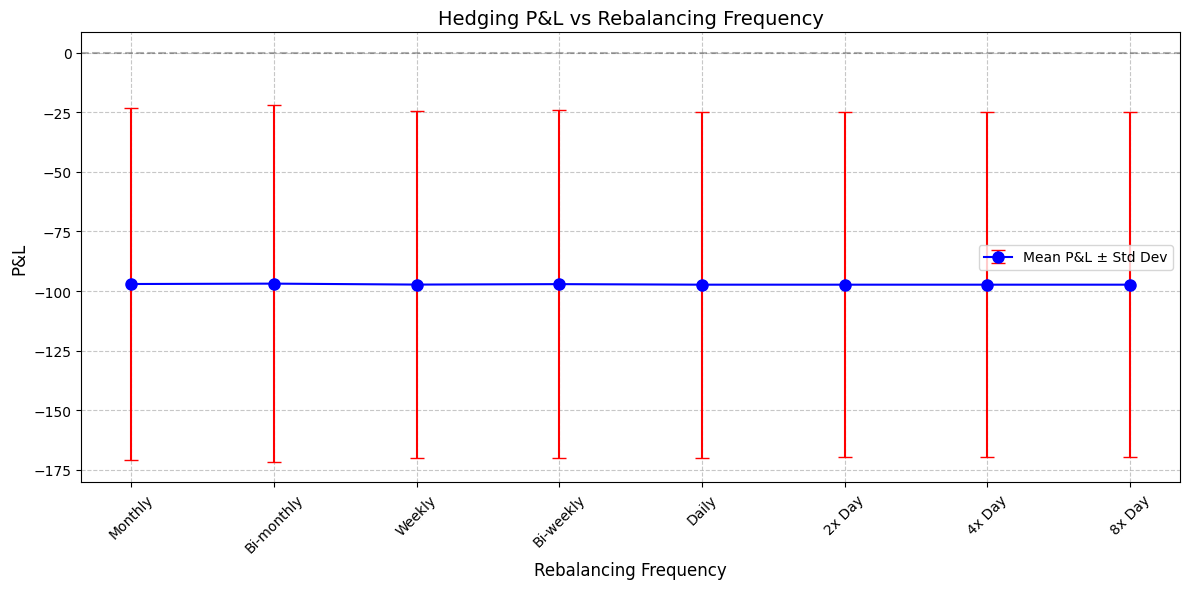

In [132]:
# Generating paths
rng = StandardNormalRNG(seed=50)
gbm_generator = GBMPathGenerator(num_paths=num_paths, num_steps=num_steps, s0=S0, drift=r - q,diffusion=v, to_time=T, rng=rng)
paths = gbm_generator.generate()

# Setting up frequencies and labels
rebalance_freqs = [12, 6, 52, 26, 252, 504, 1008, 2016]
freq_labels = ['Monthly', 'Bi-monthly', 'Weekly', 'Bi-weekly', 'Daily', '2x Day', '4x Day', '8x Day']

# Running simulations
means = []
stds = []

for freq in rebalance_freqs:
    mean_pnl, std_pnl = simulate_gamma_hedging_put_call(paths, freq)
    means.append(mean_pnl)
    stds.append(std_pnl)
    print(f"Frequency: {freq_labels[rebalance_freqs.index(freq)]}, "f"Mean P&L: {mean_pnl:.4f}, Std Dev P&L: {std_pnl:.4f}")

# Plotting results
fig = plot_hedging_results(freq_labels, means, stds)
plt.show()

#### (ii)

1) A short put option has a negative gamma, meaning its delta decreases as the stock price increases and a call option has a positive gamma, so we can use it to offset the negative gamma of the short put position hence we will go long in call option with with 𝑁call determined by the formula 𝑁call = −gamma_put/gamma_call.

2) A gamma hedge reduces the overall variance of the hedged portfolio's P&L by mitigating nonlinear risks and stabilizing delta. This leads to fewer large swings in portfolio value and results in a more predictable P&L outcome.